# 情绪表情符号分类 - PyTorch版本

## 项目概述

本项目实现了一个基于深度学习的情感分析模型，能够将输入的文本句子分类为对应的表情符号。例如：
- "I love you" → ❤️
- "I am happy" → 😊
- "I am hungry" → 🍴
- "We have a lot trouble" → 😞
- "Let us play ball" → ⚾

### 技术栈
- **PyTorch**: 深度学习框架
- **LSTM**: 长短期记忆网络，用于处理序列数据
- **GloVe**: 预训练词向量
- **Embedding Layer**: 词嵌入层

### 我们要做什么？
我们将构建一个LSTM神经网络，学习根据输入的英文句子（10个单词以内），分析出句子的情感。


### 关键步骤概述：
1. 使用预训练词向量
2. 构建LSTM神经网络
3. 文本数据的预处理方法
4. 模型训练和评估的全流程


## <font color='red'><b>🔍 调试任务说明（可按如下提示修改第3步，其它步骤的代码保持不变）</b></font>

<font color='red'><b>任务目标：这个项目需要完成以下核心步骤：</b></font>
<br>
<font color='red'><b>1. 数据加载与预处理：加载MNIST数据集并进行标准化处理</b></font>
<br>
<font color='red'><b>2. 模型构建：修改第3步的神经网络模型结构，设计合适的LSTM网络架构</b></font>
<br>
<font color='red'><b>3. 训练优化：训练模型</b></font>
<br>
<font color='red'><b>4. 评估测试：在测试集上评估模型性能，测试集准确率达到85%以上</b></font>

评分规则说明：测试集准确率在

81%-82%之间，给5分；
<br>
82%-83%之间，给10分；
<br>
83%-84%之间，给15分；
<br>
84%-85%之间，给20分；
<br>
超过85%，给25分。

---

## 目录
1. [环境设置和库导入](#1-环境设置和库导入)
2. [数据工具函数](#2-数据工具函数)
3. [PyTorch模型定义](#3-PyTorch模型定义)
4. [数据加载和预处理](#4-数据加载和预处理)
5. [创建和训练模型](#5-创建和训练模型)
6. [模型评估](#6-模型评估)
7. [测试自定义句子](#7-测试自定义句子)

In [15]:
# todo: 解压GloVe词向量文件（如果尚未解压）
!tar -xf glove.6B.50d.zip

<a id="1-环境设置和库导入"></a>
## 1. 环境设置和库导入

在这一步中，我们将导入所有必要的库并进行基础设置。

In [16]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import emoji
import csv
import warnings

# 忽略警告信息，使输出更清晰
warnings.filterwarnings('ignore')

# 设置中文字体显示 - 解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 设置图像大小和分辨率
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# 设置随机种子以确保结果可重现
torch.manual_seed(1)
np.random.seed(1)

# 检查是否有GPU可用，如果有则使用GPU加速训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"当前使用的设备: {device}")
print("如果显示'cuda'表示使用GPU加速，显示'cpu'表示使用CPU")

# 如果使用GPU，显示GPU信息
if torch.cuda.is_available():
    print(f"GPU型号: {torch.cuda.get_device_name(0)}")
    print(f"GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

当前使用的设备: cuda
如果显示'cuda'表示使用GPU加速，显示'cpu'表示使用CPU
GPU型号: NVIDIA RTX A4000
GPU内存: 15.0 GB


<a id="2-数据工具函数"></a>
## 2. 数据工具函数

这里我们定义所有数据处理和工具函数。这些函数负责：
- 读取数据文件
- 预处理文本
- 转换数据格式
- 可视化结果

In [17]:
def read_glove_vecs(glove_file):
    """
    读取GloVe预训练词向量文件
    
    参数:
        glove_file: GloVe词向量文件路径
    
    返回:
        words_to_index: 词到索引的映射字典
        index_to_words: 索引到词的映射字典  
        word_to_vec_map: 词到向量的映射字典
    """
    print(f"正在读取GloVe词向量文件: {glove_file}")
    
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        
        # 逐行读取文件
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

        # 创建词汇表索引
        i = 1
        words_to_index = {}
        index_to_words = {}
        
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
            
    print(f"成功加载 {len(words_to_index)} 个单词的词向量")
    return words_to_index, index_to_words, word_to_vec_map

def read_csv(filename='train_emoji.csv'):
    """
    读取包含文本和表情标签的CSV文件
    
    参数:
        filename: CSV文件路径
    
    返回:
        X: 文本句子数组
        Y: 表情标签数组
    """
    phrase = []
    emoji_list = []

    with open(filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji_list.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji_list, dtype=int)

    print(f"从 {filename} 加载了 {len(X)} 个样本")
    return X, Y

def convert_to_one_hot(Y, C):
    """
    将标签转换为one-hot编码格式
    
    参数:
        Y: 原始标签数组
        C: 类别数量
    
    返回:
        one-hot编码后的标签数组
    """
    Y_one_hot = np.eye(C)[Y.reshape(-1)]
    return Y_one_hot

# 定义表情符号映射字典
emoji_dictionary = {
    "0": "❤️",
    "1": "⚾",
    "2": "😊",
    "3": "😞",
    "4": "🍴"
}

def label_to_emoji(label):
    """
    将数字标签转换为对应的表情符号
    
    参数:
        label: 数字标签 (0-4)
    
    返回:
        对应的表情符号字符串
    """
    label_str = str(label)
    if label_str in emoji_dictionary:
        return emoji_dictionary[label_str]
    else:
        return "❓"

def print_predictions(X, pred):
    """
    打印预测结果，显示文本和对应的预测表情
    
    参数:
        X: 原始文本数组
        pred: 预测结果数组
    """
    print("\n预测结果:")
    for i in range(X.shape[0]):
        print(f"文本: '{X[i]}' -> 预测表情: {label_to_emoji(int(pred[i]))}")

def plot_confusion_matrix(y_actu, y_pred, title='混淆矩阵', cmap=plt.cm.Blues):
    """
    绘制混淆矩阵，可视化模型预测性能
    
    参数:
        y_actu: 真实标签
        y_pred: 预测标签
        title: 图表标题
        cmap: 颜色映射
    """
    cm = confusion_matrix(y_actu, y_pred)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(emoji_dictionary))
    plt.xticks(tick_marks, [label_to_emoji(i) for i in range(len(emoji_dictionary))])
    plt.yticks(tick_marks, [label_to_emoji(i) for i in range(len(emoji_dictionary))])
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('真实标签')
    plt.xlabel('预测标签')
    plt.tight_layout()
    plt.show()

def sentences_to_indices(X, word_to_index, max_len):
    """
    将文本句子转换为单词索引序列
    
    参数:
        X: 文本句子数组
        word_to_index: 词到索引的映射字典
        max_len: 最大序列长度
    
    返回:
        X_indices: 索引序列数组，形状为 (样本数, 最大序列长度)
    """
    m = X.shape[0]
    X_indices = np.zeros((m, max_len), dtype=np.int64)
    
    for i in range(m):
        sentence_words = (X[i].lower()).split()
        j = 0
        
        for w in sentence_words:
            if j < max_len:
                if w in word_to_index:
                    X_indices[i, j] = word_to_index[w]
                else:
                    X_indices[i, j] = 0
                j += 1
                
    print(f"已将 {m} 个句子转换为索引序列，序列长度: {max_len}")
    return X_indices

<a id="3-PyTorch模型定义"></a>
## 3. PyTorch模型定义

在这一部分，我们将定义神经网络模型的结构。我们的模型包含：
1. **预训练词嵌入层**: 将单词索引转换为词向量
2. **LSTM层**: 处理序列数据，捕捉上下文信息
3. **全连接层**: 输出分类结果

<div style="color: #FF0000; font-size: 18px; font-weight: bold; background-color: #FFF0F0; padding: 10px; border: 2px solid #FF0000; border-radius: 5px;"> 考试任务：修改下面SentimentAnalysisModel(nn.Module)里的网络模型配置，使其在第6步的模型评估中，测试集准确率超过85% </div>

In [27]:
class PretrainedEmbeddingLayer(nn.Module):
    """
    预训练词嵌入层
    
    这个层使用预训练的GloVe词向量来初始化嵌入矩阵。
    在训练过程中，这些词向量保持不变（不更新）。
    """
    def __init__(self, word_to_vec_map, word_to_index, emb_dim=50):
        """
        初始化嵌入层
        
        参数:
            word_to_vec_map: 词到向量的映射字典
            word_to_index: 词到索引的映射字典
            emb_dim: 词向量维度（默认50）
        """
        super(PretrainedEmbeddingLayer, self).__init__()
        
        vocab_len = len(word_to_index) + 1
        emb_matrix = np.zeros((vocab_len, emb_dim))
        
        for word, index in word_to_index.items():
            emb_matrix[index, :] = word_to_vec_map[word]
        
        self.embedding = nn.Embedding.from_pretrained(
            torch.FloatTensor(emb_matrix), 
            freeze=True,
            # freeze=False,
            padding_idx=0
        )
    
    def forward(self, x):
        """
        前向传播
        
        参数:
            x: 输入张量，包含单词索引，形状为 (batch_size, sequence_length)
        
        返回:
            词向量张量，形状为 (batch_size, sequence_length, embedding_dim)
        """
        return self.embedding(x)


# todo: 减少模型层级，减少隐含层，略微增大dropout比例 (使用ChatGPT-5.1辅助修改, 对话过程详见以下链接)
# todo: https://chatgpt.com/share/691ab0ed-3244-8000-9327-97f11b2dcd00
class SentimentAnalysisModel(nn.Module):
    """
    情感分析模型（在当前训练脚本下表现最好的版本）

    结构:
        - 冻结的 GloVe 词嵌入 (50d)
        - 2 层双向 LSTM（总隐藏维度 hidden_dim）
        - 取最后一层 BiLSTM 的前向 / 后向最终隐状态拼接，得到句向量
        - 小型两层 MLP 分类头
        - 输出 logits，形状 (batch_size, output_dim=5)
    """
    def __init__(self,
                 word_to_vec_map,
                 word_to_index,
                 hidden_dim: int = 96,
                 output_dim: int = 5,
                 dropout_rate: float = 0.35):
        """
        参数:
            word_to_vec_map: 词 -> 向量
            word_to_index:   词 -> 索引
            hidden_dim:      BiLSTM 输出总隐藏维度（前向 + 后向）
            output_dim:      类别数（本任务为 5）
            dropout_rate:    Dropout 比例
        """
        super(SentimentAnalysisModel, self).__init__()

        # 1. 预训练嵌入层
        self.embedding_layer = PretrainedEmbeddingLayer(
            word_to_vec_map=word_to_vec_map,
            word_to_index=word_to_index,
            emb_dim=50
        )

        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # 2. 2 层双向 LSTM
        #    - input_size = 50 (词向量维度)
        #    - hidden_size = hidden_dim // 2（每个方向的 hidden 大小）
        #    - bidirectional = True（双向）
        #    - num_layers = 2
        #    - dropout = dropout_rate（仅作用于层间）
        self.lstm = nn.LSTM(
            input_size=50,
            hidden_size=hidden_dim // 2,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate
        )

        # 3. 小型 MLP 分类头
        #    输入: 句向量 (B, hidden_dim)
        #    输出: logits (B, output_dim)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        前向传播

        参数:
            x: (batch_size, sequence_length)

        返回:
            logits: (batch_size, output_dim=5)
        """
        # 1) 词嵌入: (B, T) -> (B, T, 50)
        embeddings = self.embedding_layer(x)

        # 2) BiLSTM 编码
        #    lstm_out: (B, T, hidden_dim)
        #    h_n: (num_layers * num_directions, B, hidden_dim // 2)
        lstm_out, (h_n, c_n) = self.lstm(embeddings)

        # 3) 取最后一层的前向 & 后向最终隐状态
        #    2 层双向 LSTM:
        #       layer 0: index 0 (fwd), 1 (bwd)
        #       layer 1: index 2 (fwd), 3 (bwd)
        h_forward_last = h_n[-2, :, :]   # (B, hidden_dim // 2)
        h_backward_last = h_n[-1, :, :]  # (B, hidden_dim // 2)

        # 拼接得到整句表示: (B, hidden_dim)
        sentence_vec = torch.cat((h_forward_last, h_backward_last), dim=1)

        # 4) 通过 MLP 分类头，输出 logits
        logits = self.classifier(sentence_vec)  # (B, output_dim)

        return logits

print("模型类定义完成！")
print("我们定义了两个类:")
print("1. PretrainedEmbeddingLayer: 处理词向量嵌入")
print("2. SentimentAnalysisModel: 主要的情感分析模型")

模型类定义完成！
我们定义了两个类:
1. PretrainedEmbeddingLayer: 处理词向量嵌入
2. SentimentAnalysisModel: 主要的情感分析模型


<a id="4-数据加载和预处理"></a>
## 4. 数据加载和预处理

现在我们将加载数据并进行预处理，为模型训练做准备。

In [28]:
# 读取数据
print("读取数据文件...")
try:
    X_train, Y_train = read_csv('train_emoji.csv')
    X_test, Y_test = read_csv('test_emoji.csv')
    print("✓ 成功加载数据文件")
    
except FileNotFoundError as e:
    print(f"⚠ 警告: 找不到数据文件 {e}")
    print("\n请确保以下文件在当前目录:")
    print("- train_emoji.csv - 训练数据")
    print("- test_emoji.csv  - 测试数据") 
    print("- glove.6B.50d.txt - GloVe词向量")
    
    print("\n正在创建示例数据用于演示...")
    
    X_train = np.array([
        'I love you',
        'I am happy',
        'I am sad',
        'let us play',
        'I am hungry',
        'you are my love',
        'this is fun',
        'I feel bad',
        'play baseball',
        'I want food'
    ])
    Y_train = np.array([0, 2, 3, 1, 4, 0, 2, 3, 1, 4])
    
    X_test = np.array([
        'I like you',
        'I feel good',
        'I am disappointed',
        'play ball',
        'food time'
    ])
    Y_test = np.array([0, 2, 3, 1, 4])
    
    print("✓ 示例数据创建完成")

# 计算最大序列长度
print("\n计算序列长度...")
maxLen = len(max(X_train, key=len).split())
print(f"训练集大小: {X_train.shape[0]} 个样本")
print(f"测试集大小: {X_test.shape[0]} 个样本")
print(f"最大序列长度: {maxLen} 个单词")

# 显示一些样本
print("\n显示数据样本...")
print("训练集前5个样本:")
for i in range(min(5, len(X_train))):
    print(f"  文本: '{X_train[i]:15}' -> 标签: {Y_train[i]} {label_to_emoji(Y_train[i])}")

# 转换为one-hot编码
print("\n数据编码...")
Y_oh_train = convert_to_one_hot(Y_train, C=5)
Y_oh_test = convert_to_one_hot(Y_test, C=5)
print(f"one-hot编码形状: {Y_oh_train.shape}")

# 读取GloVe词向量
print("\n加载预训练词向量...")
try:
    word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')
    print(f"✓ 成功加载GloVe词向量")
    print(f"词汇表大小: {len(word_to_index)} 个单词")
    print(f"词向量维度: {word_to_vec_map['the'].shape[0]} 维")
    
    print("\n示例单词的词向量:")
    sample_words = ['love', 'happy', 'sad', 'play', 'food']
    for word in sample_words:
        if word in word_to_vec_map:
            print(f"  '{word}': 向量形状 {word_to_vec_map[word].shape}")
            
except FileNotFoundError:
    print("⚠ 警告: 找不到GloVe文件，创建小型词汇表用于演示")
    
    word_to_index = {
        'i': 1, 'love': 2, 'you': 3, 'am': 4, 'happy': 5, 'sad': 6, 
        'let': 7, 'us': 8, 'play': 9, 'hungry': 10, 'like': 11, 
        'feel': 12, 'good': 13, 'disappointed': 14, 'ball': 15, 
        'food': 16, 'time': 17, 'are': 18, 'my': 19, 'this': 20, 
        'is': 21, 'fun': 22, 'bad': 23, 'baseball': 24, 'want': 25
    }
    
    word_to_vec_map = {word: np.random.randn(50) for word in word_to_index.keys()}
    
    print("✓ 演示词汇表创建完成")
    print(f"词汇表大小: {len(word_to_index)} 个单词")

# 准备数据
print("\n准备训练数据...")
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)

# 转换为PyTorch张量并移动到相应设备
print("\n 转换为PyTorch张量...")
X_train_tensor = torch.LongTensor(X_train_indices).to(device)
Y_train_tensor = torch.FloatTensor(Y_oh_train).to(device)
X_test_tensor = torch.LongTensor(X_test_indices).to(device)
Y_test_tensor = torch.FloatTensor(Y_oh_test).to(device)

print(f"训练数据形状: {X_train_tensor.shape}")
print(f"训练标签形状: {Y_train_tensor.shape}")
print(f"测试数据形状: {X_test_tensor.shape}")
print(f"测试标签形状: {Y_test_tensor.shape}")

print("\n🎉 数据预处理完成！所有数据已准备好用于训练。")

读取数据文件...
从 train_emoji.csv 加载了 132 个样本
从 test_emoji.csv 加载了 56 个样本
✓ 成功加载数据文件

计算序列长度...
训练集大小: 132 个样本
测试集大小: 56 个样本
最大序列长度: 10 个单词

显示数据样本...
训练集前5个样本:
  文本: 'never talk to me again' -> 标签: 3 😞
  文本: 'I am proud of your achievements' -> 标签: 2 😊
  文本: 'It is the worst day in my life' -> 标签: 3 😞
  文本: 'Miss you so much' -> 标签: 0 ❤️
  文本: 'food is life   ' -> 标签: 4 🍴

数据编码...
one-hot编码形状: (132, 5)

加载预训练词向量...
正在读取GloVe词向量文件: glove.6B.50d.txt
成功加载 400000 个单词的词向量
✓ 成功加载GloVe词向量
词汇表大小: 400000 个单词
词向量维度: 50 维

示例单词的词向量:
  'love': 向量形状 (50,)
  'happy': 向量形状 (50,)
  'sad': 向量形状 (50,)
  'play': 向量形状 (50,)
  'food': 向量形状 (50,)

准备训练数据...
已将 132 个句子转换为索引序列，序列长度: 10
已将 56 个句子转换为索引序列，序列长度: 10

 转换为PyTorch张量...
训练数据形状: torch.Size([132, 10])
训练标签形状: torch.Size([132, 5])
测试数据形状: torch.Size([56, 10])
测试标签形状: torch.Size([56, 5])

🎉 数据预处理完成！所有数据已准备好用于训练。


<a id="5-创建和训练模型"></a>
## 5. 创建和训练模型

现在我们将创建模型实例并开始训练过程。

 创建模型实例...
✓ 模型创建完成

显示模型结构...
模型结构:
SentimentAnalysisModel(
  (embedding_layer): PretrainedEmbeddingLayer(
    (embedding): Embedding(400001, 50, padding_idx=0)
  )
  (lstm): LSTM(50, 48, num_layers=2, batch_first=True, dropout=0.35, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=96, out_features=96, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.35, inplace=False)
    (3): Linear(in_features=96, out_features=5, bias=True)
  )
)

计算模型参数...
总参数数量: 20,104,311
可训练参数数量: 104,261
冻结参数数量: 20,000,050 (词嵌入层)

定义损失函数和优化器...
损失函数: CrossEntropyLoss
优化器: Adam
学习率: 0.001

开始训练模型...
训练配置:
- 训练轮数: 100
- 批大小: 8
- 训练样本数: 132
- 每轮批次数: 17

开始训练循环...
轮次 [ 20/100], 平均损失: 0.0298
轮次 [ 40/100], 平均损失: 0.0008
轮次 [ 60/100], 平均损失: 0.0002
轮次 [ 80/100], 平均损失: 0.0001
轮次 [100/100], 平均损失: 0.0001

🎉 模型训练完成！

绘制训练损失曲线...


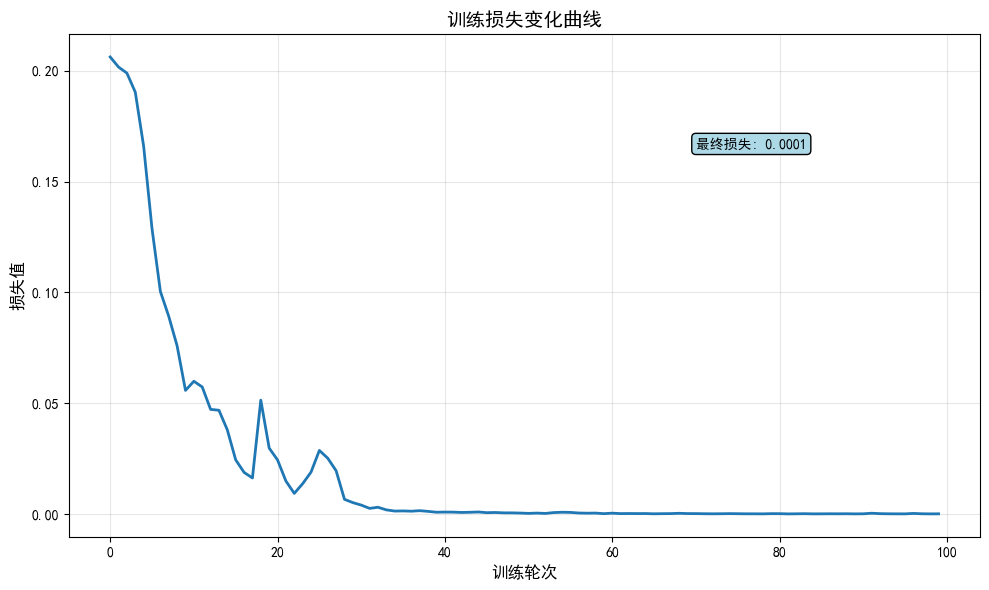


📊 损失曲线说明:
- 曲线下降表示模型正在学习
- 曲线平稳表示模型可能已经收敛
- 如果曲线波动很大，可能需要调整学习率


In [29]:
# 创建模型实例
print(" 创建模型实例...")
model = SentimentAnalysisModel(word_to_vec_map, word_to_index).to(device)
print("✓ 模型创建完成")

# 打印模型结构
print("\n显示模型结构...")
print("模型结构:")
print(model)

# 计算参数数量
print("\n计算模型参数...")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"总参数数量: {total_params:,}")
print(f"可训练参数数量: {trainable_params:,}")
print(f"冻结参数数量: {total_params - trainable_params:,} (词嵌入层)")

# 定义损失函数和优化器
print("\n定义损失函数和优化器...")
criterion = nn.CrossEntropyLoss()
print(f"损失函数: {criterion.__class__.__name__}")

optimizer = optim.Adam(model.parameters(), lr=0.001)
print(f"优化器: {optimizer.__class__.__name__}")
print(f"学习率: {optimizer.param_groups[0]['lr']}")

# 训练模型
print("\n开始训练模型...")
epochs = 100
batch_size = 8

print(f"训练配置:")
print(f"- 训练轮数: {epochs}")
print(f"- 批大小: {batch_size}")
print(f"- 训练样本数: {len(X_train_tensor)}")
print(f"- 每轮批次数: {len(X_train_tensor) // batch_size + 1}")

train_losses = []

print("\n开始训练循环...")
for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    permutation = torch.randperm(X_train_tensor.size(0))
    
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = X_train_tensor[indices]
        batch_y = Y_train_tensor[indices]
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(X_train_tensor)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 20 == 0:
        print(f'轮次 [{epoch+1:3d}/{epochs}], 平均损失: {avg_loss:.4f}')

print("\n🎉 模型训练完成！")

# 绘制训练损失曲线
print("\n绘制训练损失曲线...")
plt.figure(figsize=(10, 6))
plt.plot(train_losses, linewidth=2)
plt.title('训练损失变化曲线', fontsize=14)
plt.xlabel('训练轮次', fontsize=12)
plt.ylabel('损失值', fontsize=12)
plt.grid(True, alpha=0.3)

plt.text(len(train_losses)*0.7, max(train_losses)*0.8, 
         f'最终损失: {train_losses[-1]:.4f}', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

plt.tight_layout()
plt.show()

print("\n📊 损失曲线说明:")
print("- 曲线下降表示模型正在学习")
print("- 曲线平稳表示模型可能已经收敛")
print("- 如果曲线波动很大，可能需要调整学习率")

<a id="6-模型评估"></a>
## 6. 模型评估

现在我们将评估训练好的模型在训练集和测试集上的表现。

评估模型性能...

计算训练集准确率...
训练集准确率: 1.0000 (100.00%)

计算测试集准确率...
测试集准确率: 0.8571 (85.71%)
测试集损失: 1.1216

分析错误预测...
总共错误预测: 8/56

错误预测样本详情:
------------------------------------------------------------
样本 1:
  文本: 'he got a very nice raise	'
  真实: 😊 (标签2)
  预测: ❤️ (标签0)
------------------------------------------------------------
样本 2:
  文本: 'she got me a nice present	'
  真实: 😊 (标签2)
  预测: ❤️ (标签0)
------------------------------------------------------------
样本 3:
  文本: 'This girl is messing with me	'
  真实: 😞 (标签3)
  预测: ❤️ (标签0)
------------------------------------------------------------
样本 4:
  文本: 'you brighten my day	'
  真实: 😊 (标签2)
  预测: ❤️ (标签0)
------------------------------------------------------------
样本 5:
  文本: 'My life is so boring	'
  真实: 😞 (标签3)
  预测: ❤️ (标签0)
------------------------------------------------------------
样本 6:
  文本: 'will you be my valentine	'
  真实: 😊 (标签2)
  预测: ❤️ (标签0)
------------------------------------------------------------
样本 7:
  文本: 'I love you to th

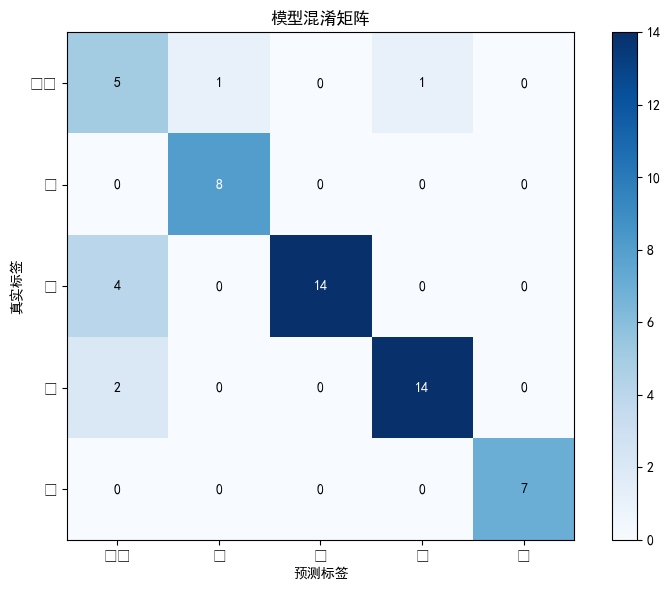


📈 模型性能总结
训练集准确率: 100.00%
测试集准确率: 85.71%
测试集损失: 1.1216
错误预测数: 8/56
🎉 优秀！模型表现非常好！


In [30]:
# 评估模型
print("评估模型性能...")
model.eval()

with torch.no_grad():
    print("\n计算训练集准确率...")
    train_outputs = model(X_train_tensor)
    train_pred = torch.argmax(train_outputs, dim=1)
    train_true = torch.argmax(Y_train_tensor, dim=1)
    train_accuracy = (train_pred == train_true).float().mean()
    
    print(f"训练集准确率: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
    
    print("\n计算测试集准确率...")
    test_outputs = model(X_test_tensor)
    test_pred = torch.argmax(test_outputs, dim=1)
    test_true = torch.argmax(Y_test_tensor, dim=1)
    test_accuracy = (test_pred == test_true).float().mean()
    
    print(f"测试集准确率: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    
    test_loss = criterion(test_outputs, Y_test_tensor)
    print(f"测试集损失: {test_loss:.4f}")

# 显示错误预测的样本
print("\n分析错误预测...")
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
pred_np = test_outputs.cpu().numpy()

error_count = 0
error_samples = []

for i in range(len(X_test)):
    num = np.argmax(pred_np[i])
    if (num != Y_test[i]):
        error_count += 1
        error_samples.append({
            'text': X_test[i],
            'true_label': Y_test[i],
            'pred_label': num,
            'true_emoji': label_to_emoji(Y_test[i]),
            'pred_emoji': label_to_emoji(num)
        })

print(f"总共错误预测: {error_count}/{len(X_test)}")

if error_count > 0:
    print("\n错误预测样本详情:")
    print("-" * 60)
    for i, error in enumerate(error_samples[:10]):
        print(f"样本 {i+1}:")
        print(f"  文本: '{error['text']}'")
        print(f"  真实: {error['true_emoji']} (标签{error['true_label']})")
        print(f"  预测: {error['pred_emoji']} (标签{error['pred_label']})")
        print("-" * 60)
else:
    print("🎉 完美！所有测试样本都预测正确！")

# 绘制混淆矩阵
print("\n绘制混淆矩阵...")
y_true = test_true.cpu().numpy()
y_pred = test_pred.cpu().numpy()

print("混淆矩阵说明:")
print("- 对角线上的数字表示正确预测的数量")
print("- 非对角线上的数字表示错误预测的数量")
print("- 行表示真实标签，列表示预测标签")

plot_confusion_matrix(y_true, y_pred, '模型混淆矩阵')

# 模型性能总结
print("\n" + "="*50)
print("📈 模型性能总结")
print("="*50)
print(f"训练集准确率: {train_accuracy*100:.2f}%")
print(f"测试集准确率: {test_accuracy*100:.2f}%")
print(f"测试集损失: {test_loss:.4f}")
print(f"错误预测数: {error_count}/{len(X_test)}")
print("="*50)

if test_accuracy > 0.85:
    print("🎉 优秀！模型表现非常好！")
elif test_accuracy > 0.8:
    print("👍 良好！模型表现不错！")
elif test_accuracy > 0.5:
    print("⚠ 一般！模型还有改进空间。")
else:
    print("❌ 较差！建议检查数据或调整模型。")

<a id="7-测试自定义句子"></a>
## 7. 测试自定义句子

现在让我们用训练好的模型来预测一些自定义的句子，看看模型的实际表现！

In [22]:
# 测试自定义句子
print("🔮 现在让我们测试一些自定义句子！")
print("="*60)

test_sentences = [
    'very happy',
    'I love you',
    'I am sad',
    'let us play ball',
    'I am hungry',
    'this is amazing',
    'I feel terrible',
    'we won the game',
    'time for dinner',
    'you are my everything'
]

print("测试句子列表:")
for i, sentence in enumerate(test_sentences, 1):
    print(f"{i:2d}. '{sentence}'")

print("\n" + "="*60)
print("预测结果:")
print("="*60)

model.eval()

with torch.no_grad():
    for sentence in test_sentences:
        x_test = np.array([sentence])
        X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
        X_test_tensor = torch.LongTensor(X_test_indices).to(device)
        
        prediction = model(X_test_tensor)
        pred_class = torch.argmax(prediction, dim=1).cpu().numpy()[0]
        pred_emoji = label_to_emoji(pred_class)
        confidence = torch.max(prediction).cpu().numpy()
        
        print(f"文本: '{sentence:20}' -> 预测: {pred_emoji:3} | 置信度: {confidence:.3f} | 标签: {pred_class}")

print("="*60)

# # todo: 注释掉下面的代码块以便于运行
# # 让用户输入自定义句子
# print("\n💬 现在您可以测试自己的句子！")
# print("输入 'quit' 退出测试")
# print("-" * 40)
#
# while True:
#     user_input = input("请输入一个句子: ").strip()
#
#     if user_input.lower() == 'quit':
#         print("谢谢使用！再见！")
#         break
#
#     if not user_input:
#         print("请输入有效的句子！")
#         continue
#
#     with torch.no_grad():
#         x_test = np.array([user_input])
#         X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
#         X_test_tensor = torch.LongTensor(X_test_indices).to(device)
#
#         prediction = model(X_test_tensor)
#         pred_class = torch.argmax(prediction, dim=1).cpu().numpy()[0]
#         pred_emoji = label_to_emoji(pred_class)
#         confidence = torch.max(prediction).cpu().numpy()
#
#         probabilities = prediction.cpu().numpy()[0]
#
#         print(f"\n🔍 分析结果:")
#         print(f"   输入: '{user_input}'")
#         print(f"   预测: {pred_emoji} (标签 {pred_class})")
#         print(f"   置信度: {confidence:.3f}")
#
#         print(f"\n📊 所有类别概率:")
#         for i in range(5):
#             emoji_char = label_to_emoji(i)
#             prob = probabilities[i]
#             bar = "█" * int(prob * 20)
#             print(f"   {emoji_char} {i}: {prob:.3f} {bar}")
#
#     print("-" * 40)

🔮 现在让我们测试一些自定义句子！
测试句子列表:
 1. 'very happy'
 2. 'I love you'
 3. 'I am sad'
 4. 'let us play ball'
 5. 'I am hungry'
 6. 'this is amazing'
 7. 'I feel terrible'
 8. 'we won the game'
 9. 'time for dinner'
10. 'you are my everything'

预测结果:
已将 1 个句子转换为索引序列，序列长度: 10
文本: 'very happy          ' -> 预测: 😊   | 置信度: 8.097 | 标签: 2
已将 1 个句子转换为索引序列，序列长度: 10
文本: 'I love you          ' -> 预测: ❤️  | 置信度: 6.658 | 标签: 0
已将 1 个句子转换为索引序列，序列长度: 10
文本: 'I am sad            ' -> 预测: 😞   | 置信度: 6.650 | 标签: 3
已将 1 个句子转换为索引序列，序列长度: 10
文本: 'let us play ball    ' -> 预测: ⚾   | 置信度: 9.771 | 标签: 1
已将 1 个句子转换为索引序列，序列长度: 10
文本: 'I am hungry         ' -> 预测: 🍴   | 置信度: 8.434 | 标签: 4
已将 1 个句子转换为索引序列，序列长度: 10
文本: 'this is amazing     ' -> 预测: 😊   | 置信度: 9.256 | 标签: 2
已将 1 个句子转换为索引序列，序列长度: 10
文本: 'I feel terrible     ' -> 预测: 😞   | 置信度: 9.492 | 标签: 3
已将 1 个句子转换为索引序列，序列长度: 10
文本: 'we won the game     ' -> 预测: ⚾   | 置信度: 10.133 | 标签: 1
已将 1 个句子转换为索引序列，序列长度: 10
文本: 'time for dinner     ' -> 预测: 🍴   | 置信度: 8.988 | 标签: 4
已将 1